# DQN


### Training of DQN in Tensorflow
--------------------------

In [1]:
#
from util import *
from dlg_manager import *
from alg import *
from agent import *
from user_sim import *
from state_tracker import *
import random
from config import *
import matplotlib.pyplot as plt
import numpy as np
from nlg import *
from six.moves import cPickle as pickle
import IPython
import copy, argparse, json

%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Load Data
-------------------

#### Action Set

In [2]:
#
act_set_path = './data/dia_acts.txt'
act_set = text_to_dict(act_set_path)
sample_dict(act_set)

keys = 11
Sample of dict:
- confirm_question: 2
- request: 0
- not_sure: 10
- inform: 1
- closing: 5


### slot set

In [3]:
#
slots_set_path = "./data/slot_set.txt"
slot_set = text_to_dict(slots_set_path)
sample_dict(slot_set)

keys = 29
Sample of dict:
- date: 5
- mc_list: 28
- taskcomplete: 16
- numberofkids: 15
- movie_series: 11


### movie dic: info about movie

In [4]:
#
movie_kb_path = "./data/movie_kb.1k.p"
movie_kb = pickle.load(open(movie_kb_path, 'rb'), encoding="latin")
sample_dict(movie_kb, sample_size=1)

keys = 991
Sample of dict:
- 25: {'moviename': 'london has fallen', 'theater': 'many', 'city': 'seattle', 'starttime': 'latest showing', 'other': 'search theater', 'date': 'tonight'}


# Language Generator (pretrained)
-------------------

In [5]:
#
nlg_model_path = './data/trained_model/nlg/lstm_tanh_relu_[1468202263.38]_2_0.610.p'
nlg_model = Nlg()
nlg_model.load_nlg_model(nlg_model_path)
diaact_nl_pairs_path = "./data/nlg/dia_act_nl_pairs.v6.json"
nlg_model.load_predefine_act_nl_pairs(diaact_nl_pairs_path)

## Model Params

In [6]:
#
model_params = pickle.load(open(nlg_model_path, 'rb'), encoding='latin1')
params = model_params['params']
params['batch_size'] = 16
batch_size = 16
save_check_point = 20
params['trained_model_path'] = None
for k in params:
    print("{}: {}".format(k, params[k]))

write_model_dir: .\checkpoints\template\07102016\
split_method: 1
momentum: 0.1
batch_size: 16
model: lstm_tanh
reg_cost: 0.001
learning_rate: 0.001
save_check_point: 20
valid_test: 0
pretrained_model_path: None
max_epochs: 200
hidden_size: 100
slot_rep: 1
feed_recurrence: 0
check_point: 20
cv_fold: 6
eva_metric: 2
activation_func: relu
sdgtype: rmsprop
act_set: data/dia_acts.txt
smooth_eps: 1e-08
slot_set: data/slot_set.txt
dia_slot_val: 2
trained_model_path: None
grad_clip: -0.0001
decay_rate: 0.999
init_rnn: 0
data_path: .\data\movieMultiLine.Annot.Corrected.Final.v3.csv


# User Simulator
-------------------

### goal

In [7]:
#
goal_file_path = './data/user_goals_first_turn_template.part.movie.v1.p'
all_goal_set = pickle.load(open(goal_file_path, 'rb'), encoding="latin")
print("goals length: {}".format(len(all_goal_set)))
print("Sample the first goal: \n{}".format(all_goal_set[0]))

goals length: 128
Sample the first goal: 
{'diaact': 'request', 'request_slots': {}, 'inform_slots': {'numberofpeople': '1', 'moviename': 'zootopia', 'state': 'al', 'theater': 'carmike summit 16', 'city': 'birmingham', 'starttime': 'around 2pm', 'date': 'today'}}


### Split goal set

In [8]:
# split goal set
split_fold = params.get('split_fold', 5)
goal_set = {'train':[], 'valid':[], 'test':[], 'all':[]}
for u_goal_id, u_goal in enumerate(all_goal_set):
    if u_goal_id % split_fold == 1: goal_set['test'].append(u_goal)
    else: goal_set['train'].append(u_goal)
    goal_set['all'].append(u_goal)
print(len(goal_set['train']))
print(len(goal_set['valid']))
print(len(goal_set['test']))
print(len(goal_set['all']))

102
0
26
128


### user simulator param

In [9]:
#
usersim_params = {}
usersim_params['max_turn'] = 40
usersim_params['slot_err_prob'] = 0.00
# slot_err_mode: 0 for slot_val only; 1 for three errs
usersim_params['slot_err_mode'] = 0
usersim_params['intent_err_prob'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
usersim_params['run_mode'] = 0
# 0 for dia_act level; 1 for NL level
usersim_params['act_level'] = 0
# train/test/all; default is all
usersim_params['learn_phase'] = 'all'

### a movie dictionary for user simulator - slot:possible values

In [10]:
#
movie_dict_path = './data/user/dicts.v3.p'
movie_dictionary = pickle.load(open(movie_dict_path, 'rb'), encoding="latin")
samples = sample_dict(movie_dictionary, sample_size=1)

keys = 20
Sample of dict:
- numberofpeople: ['2', '5', 'two', '9', 'three', '4', '3', '6', '1', 'four', '2 adult', 'one', '7', ' 2', 'single', '8']


###  Create a User

In [11]:
user = RuleSimulator(movie_dictionary, act_set, slot_set, goal_set, usersim_params)
user.set_nlg_model(nlg_model)

# Agent
-------------------

## param

In [12]:
#
agent_params = {}
# maximum length of each dialog (default=20, 0=no maximum length)
agent_params['max_turn'] = 40
# Epsilon to determine stochasticity of epsilon-greedy agent policies
agent_params['epsilon'] = 0
# run_mode: 0 for default NL; 1 for dia_act; 2 for both
agent_params['agent_run_mode'] = 3
# 0 for dia_act level; 1 for NL level
agent_params['agent_act_level'] = 0

############### DQN #################
# the size for experience replay
agent_params['experience_replay_pool_size'] = 10000
# # the hidden size for DQN
agent_params['dqn_hidden_size'] = 60
agent_params['batch_size'] = 16
# # gamma for DQN
agent_params['gamma'] = 0.9
# # predict model for DQN
agent_params['predict_mode'] = True
agent_params['trained_model_path'] = params['pretrained_model_path']
#####################################
print("pretrained model path = {}".format(agent_params['trained_model_path']))
# 0: no warm start; 1: warm start for training
agent_params['warm_start'] = 1
# run_mode: 0 for NL; 1 for dia_act
agent_params['cmd_input_mode'] = 0

success_rate_threshold = 0.3

pretrained model path = None


### create an agent

In [13]:
# agent = RequestBasicsAgent(movie_kb, act_set, slot_set, agent_params)
# agent = AgentDQN(movie_kb, act_set, slot_set, agent_params)
# agt = 9
agent = DQNAgentTF(movie_kb, act_set, slot_set, agent_params)
agt = 10
agent.set_nlg_model(nlg_model)

agent_run_mode:3


# Dialog Manager
-------------------

In [14]:
dlg_manager = DlgManager(agent, user, act_set, slot_set, movie_kb)

## Running Episodes
-------------------

### Param

In [15]:
#
status = {'successes': 0, 'count': 0, 'cumulative_reward': 0}
# the size of validation set
simulation_epoch_size = 100
# the number of epochs for warm start 
warm_start_epochs = 120
num_episodes = 100

In [16]:
""" Warm_Start Simulation (by Rule Policy) """
def warm_start_simulation():
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(warm_start_epochs):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("warm_start simulation episode %s: Success" % (episode))
#                 else: print ("warm_start simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        if len(agent.experience_replay_pool) >= agent.experience_replay_pool_size:
            break
    
    agent.warm_start = 2
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print ("Warm_Start %s epochs, success rate %s, ave reward %s, ave turns %s" % (episode+1, res['success_rate'], res['ave_reward'], res['ave_turns']))
    print ("Current experience replay buffer size %s" % (len(agent.experience_replay_pool)))

In [18]:
def simulation_epoch(simulation_epoch_size):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    res = {}
    for episode in range(simulation_epoch_size):
        dlg_manager.init_episode()
        episode_over = False
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
            if episode_over:
                if reward > 0: 
                    successes += 1
#                     print ("simulation episode %s: Success" % (episode))
#                 else: print ("simulation episode %s: Fail" % (episode))
                cumulative_turns += dlg_manager.state_tracker.turn_count
    
    res['success_rate'] = float(successes)/simulation_epoch_size
    res['ave_reward'] = float(cumulative_reward)/simulation_epoch_size
    res['ave_turns'] = float(cumulative_turns)/simulation_epoch_size
    print("simulation success rate %s, ave reward %s, ave turns %s" % (res['success_rate'], res['ave_reward'], res['ave_turns']))
    return res

In [22]:
def run_episodes(count, status):
    successes = 0
    cumulative_reward = 0
    cumulative_turns = 0
    
    
    if agt == 9 and params['trained_model_path'] == None and agent.warm_start == 1:
        print ('warm_start starting ...')
        warm_start_simulation()
        print ('warm_start finished, start RL training ...')
    
    for episode in range(count):
        print ("Episode: %s" % (episode))
        dlg_manager.init_episode()
        episode_over = False
        
        while(not episode_over):
            episode_over, reward = dlg_manager.step()
            cumulative_reward += reward
                
            if episode_over:
                if reward > 0:
                    print ("Successful Dialog!")
                    successes += 1
#                 else: print ("Failed Dialog!")
                
                cumulative_turns += dlg_manager.state_tracker.turn_count
        
        # simulation
        if agt >= 9 and params['trained_model_path'] == None:
            agent.predict_mode = True
            simulation_res = simulation_epoch(simulation_epoch_size)
            
            performance_records['success_rate'][episode] = simulation_res['success_rate']
            performance_records['ave_turns'][episode] = simulation_res['ave_turns']
            performance_records['ave_reward'][episode] = simulation_res['ave_reward']
            
            if simulation_res['success_rate'] >= best_res['success_rate']:
                if simulation_res['success_rate'] >= success_rate_threshold: # threshold = 0.30
                    agent.experience_replay_pool = [] 
                    simulation_epoch(simulation_epoch_size)
                
#             if simulation_res['success_rate'] > best_res['success_rate']:
#                 best_model['model'] = copy.deepcopy(agent)
#                 best_res['success_rate'] = simulation_res['success_rate']
#                 best_res['ave_reward'] = simulation_res['ave_reward']
#                 best_res['ave_turns'] = simulation_res['ave_turns']
#                 best_res['epoch'] = episode
                
            agent.train(batch_size, 1)
            if agt == 10: agent.model.update_target_params()
            else: agent.clone_dqn = copy.deepcopy(agent.dqn)
                
            agent.predict_mode = False
            
            print ("Simulation success rate %s, Ave reward %s, Ave turns %s, Best success rate %s" % (performance_records['success_rate'][episode], performance_records['ave_reward'][episode], performance_records['ave_turns'][episode], best_res['success_rate']))
#             if episode % save_check_point == 0 and params['trained_model_path'] == None: # save the model every 10 episodes
#                 save_model(params['write_model_dir'], agt, best_res['success_rate'], best_model['model'], best_res['epoch'], episode)
#                 save_performance_records(params['write_model_dir'], agt, performance_records)
        curve.append(successes/(episode+1))
        print("Progress: %s / %s, Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (episode+1, count, successes, episode+1, float(cumulative_reward)/(episode+1), float(cumulative_turns)/(episode+1)))
    print("Success rate: %s / %s Avg reward: %.2f Avg turns: %.2f" % (successes, count, float(cumulative_reward)/count, float(cumulative_turns)/count))
    status['successes'] += successes
    status['count'] += count
    
#     if agt == 9 and params['traained_model_path'] == None:
#         save_model(params['write_model_dir'], agt, float(successes)/count, best_model['model'], best_res['epoch'], count)
#         save_performance_records(params['write_model_dir'], agt, performance_records)


## Run a Warm Start

# Train & Eval
-------------------

In [23]:
# def train_agent(agent = agent, num_episode = 1000, num_batches = 100, batch_size = 10, status=status, eval_every = 10, show_every = 100):
#     succ_rates = []
#     epochs = list(range(eval_every, num_episode+1, eval_every))
#     print(epochs)
#     curr_succ_rate = None
#     curr_loss      = None
#     for n_epo in epochs:
#         print("-=-=-=-=-=-= Running: {} - Success = {} | Loss = {} -=-=-=-=-=-=".format(n_epo, curr_succ_rate, curr_loss))
#         # collect experience
#         run_episodes(agent, num_episode=eval_every, status=status, record_training_data = True, is_training = True)
#         # train
#         curr_loss = agent.train(batch_size=batch_size, num_batches=num_batches, show_every = show_every)
#         # eval
#         curr_succ_rate = run_episodes(agent, num_episode=eval_every, status=status, record_training_data = False)
#         display.HTML('<h3>{}</h3> '.format("Success Rate: {}".format(curr_succ_rate)))
#         succ_rates.append(curr_succ_rate)
        
#     return {"x": epochs, 'success_rate': succ_rates}

In [24]:
performance_records = {}
performance_records['success_rate'] = {}
performance_records['ave_turns'] = {}
performance_records['ave_reward'] = {}

best_model = {}
best_res = {'success_rate': 0, 'ave_reward':float('-inf'), 'ave_turns': float('inf'), 'epoch':0}

curve = []
agent.warm_start = 1
run_episodes(100, status)

Episode: 0
simulation success rate 0.41, ave reward 2.2, ave turns 16.0
simulation success rate 0.41, ave reward 2.2, ave turns 16.0
Train on : 800
cur bellman err 25.4993, experience replay pool 800
Simulation success rate 0.41, Ave reward 2.2, Ave turns 16.0, Best success rate 0
Progress: 1 / 100, Success rate: 0 / 1 Avg reward: -47.00 Avg turns: 16.00
Episode: 1
simulation success rate 0.31, ave reward -9.8, ave turns 16.0
simulation success rate 0.35, ave reward -5.0, ave turns 16.0
Train on : 800
cur bellman err 27.2115, experience replay pool 800
Simulation success rate 0.31, Ave reward -9.8, Ave turns 16.0, Best success rate 0
Progress: 2 / 100, Success rate: 0 / 2 Avg reward: -47.00 Avg turns: 16.00
Episode: 2
Successful Dialog!
simulation success rate 0.34, ave reward -6.2, ave turns 16.0
simulation success rate 0.47, ave reward 9.4, ave turns 16.0
Train on : 800
cur bellman err 22.6569, experience replay pool 800
Simulation success rate 0.34, Ave reward -6.2, Ave turns 16.0, 

simulation success rate 0.37, ave reward -2.6, ave turns 16.0
simulation success rate 0.36, ave reward -3.8, ave turns 16.0
Train on : 800
cur bellman err 7.9935, experience replay pool 800
Simulation success rate 0.37, Ave reward -2.6, Ave turns 16.0, Best success rate 0
Progress: 24 / 100, Success rate: 10 / 24 Avg reward: 3.00 Avg turns: 16.00
Episode: 24
simulation success rate 0.41, ave reward 2.2, ave turns 16.0
simulation success rate 0.36, ave reward -3.8, ave turns 16.0
Train on : 800
cur bellman err 7.9423, experience replay pool 800
Simulation success rate 0.41, Ave reward 2.2, Ave turns 16.0, Best success rate 0
Progress: 25 / 100, Success rate: 10 / 25 Avg reward: 1.00 Avg turns: 16.00
Episode: 25
simulation success rate 0.38, ave reward -1.4, ave turns 16.0
simulation success rate 0.39, ave reward -0.2, ave turns 16.0
Train on : 800
cur bellman err 8.1857, experience replay pool 800
Simulation success rate 0.38, Ave reward -1.4, Ave turns 16.0, Best success rate 0
Progres

simulation success rate 0.42, ave reward 3.4, ave turns 16.0
simulation success rate 0.4, ave reward 1.0, ave turns 16.0
Train on : 800
cur bellman err 3.4902, experience replay pool 800
Simulation success rate 0.42, Ave reward 3.4, Ave turns 16.0, Best success rate 0
Progress: 47 / 100, Success rate: 20 / 47 Avg reward: 4.06 Avg turns: 16.00
Episode: 47
simulation success rate 0.43, ave reward 4.6, ave turns 16.0
simulation success rate 0.36, ave reward -3.8, ave turns 16.0
Train on : 800
cur bellman err 2.2342, experience replay pool 800
Simulation success rate 0.43, Ave reward 4.6, Ave turns 16.0, Best success rate 0
Progress: 48 / 100, Success rate: 20 / 48 Avg reward: 3.00 Avg turns: 16.00
Episode: 48
Successful Dialog!
simulation success rate 0.34, ave reward -6.2, ave turns 16.0
simulation success rate 0.47, ave reward 9.4, ave turns 16.0
Train on : 800
cur bellman err 2.9168, experience replay pool 800
Simulation success rate 0.34, Ave reward -6.2, Ave turns 16.0, Best success 

simulation success rate 0.37, ave reward -2.6, ave turns 16.0
simulation success rate 0.45, ave reward 7.0, ave turns 16.0
Train on : 800
cur bellman err 1.6312, experience replay pool 800
Simulation success rate 0.37, Ave reward -2.6, Ave turns 16.0, Best success rate 0
Progress: 70 / 100, Success rate: 30 / 70 Avg reward: 4.43 Avg turns: 16.00
Episode: 70
Successful Dialog!
simulation success rate 0.39, ave reward -0.2, ave turns 16.0
simulation success rate 0.36, ave reward -3.8, ave turns 16.0
Train on : 800
cur bellman err 3.3360, experience replay pool 800
Simulation success rate 0.39, Ave reward -0.2, Ave turns 16.0, Best success rate 0
Progress: 71 / 100, Success rate: 31 / 71 Avg reward: 5.39 Avg turns: 16.00
Episode: 71
simulation success rate 0.39, ave reward -0.2, ave turns 16.0
simulation success rate 0.38, ave reward -1.4, ave turns 16.0
Train on : 800
cur bellman err 1.4642, experience replay pool 800
Simulation success rate 0.39, Ave reward -0.2, Ave turns 16.0, Best su

simulation success rate 0.37, ave reward -2.6, ave turns 16.0
simulation success rate 0.4, ave reward 1.0, ave turns 16.0
Train on : 800
cur bellman err 0.8696, experience replay pool 800
Simulation success rate 0.37, Ave reward -2.6, Ave turns 16.0, Best success rate 0
Progress: 93 / 100, Success rate: 37 / 93 Avg reward: 0.74 Avg turns: 16.00
Episode: 93
simulation success rate 0.42, ave reward 3.4, ave turns 16.0
simulation success rate 0.41, ave reward 2.2, ave turns 16.0
Train on : 800
cur bellman err 2.5036, experience replay pool 800
Simulation success rate 0.42, Ave reward 3.4, Ave turns 16.0, Best success rate 0
Progress: 94 / 100, Success rate: 37 / 94 Avg reward: 0.23 Avg turns: 16.00
Episode: 94
Successful Dialog!
simulation success rate 0.46, ave reward 8.2, ave turns 16.0
simulation success rate 0.38, ave reward -1.4, ave turns 16.0
Train on : 800
cur bellman err 2.4857, experience replay pool 800
Simulation success rate 0.46, Ave reward 8.2, Ave turns 16.0, Best success 

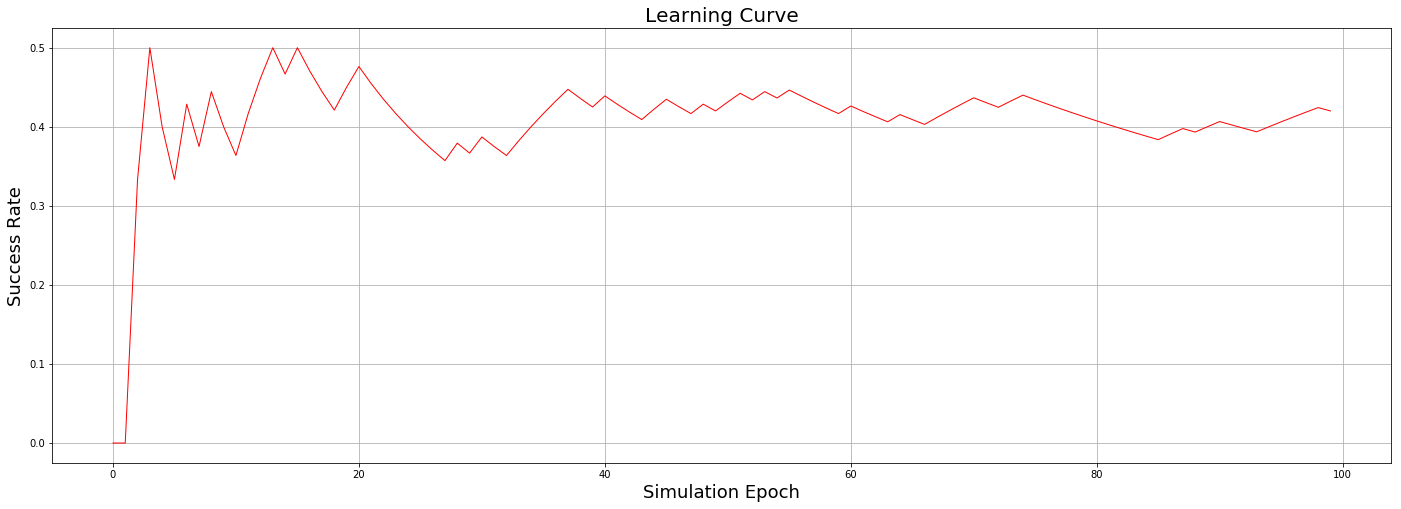

In [25]:
draw_learning_curve(curve)

In [26]:
curve

[0.0,
 0.0,
 0.3333333333333333,
 0.5,
 0.4,
 0.3333333333333333,
 0.42857142857142855,
 0.375,
 0.4444444444444444,
 0.4,
 0.36363636363636365,
 0.4166666666666667,
 0.46153846153846156,
 0.5,
 0.4666666666666667,
 0.5,
 0.47058823529411764,
 0.4444444444444444,
 0.42105263157894735,
 0.45,
 0.47619047619047616,
 0.45454545454545453,
 0.43478260869565216,
 0.4166666666666667,
 0.4,
 0.38461538461538464,
 0.37037037037037035,
 0.35714285714285715,
 0.3793103448275862,
 0.36666666666666664,
 0.3870967741935484,
 0.375,
 0.36363636363636365,
 0.38235294117647056,
 0.4,
 0.4166666666666667,
 0.43243243243243246,
 0.4473684210526316,
 0.4358974358974359,
 0.425,
 0.43902439024390244,
 0.42857142857142855,
 0.4186046511627907,
 0.4090909090909091,
 0.4222222222222222,
 0.43478260869565216,
 0.425531914893617,
 0.4166666666666667,
 0.42857142857142855,
 0.42,
 0.43137254901960786,
 0.4423076923076923,
 0.4339622641509434,
 0.4444444444444444,
 0.43636363636363634,
 0.44642857142857145,
 0.43